In [30]:
!python -V

Python 3.12.3


In [31]:
import pandas as pd

In [32]:
import pickle

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

In [34]:
from sklearn.feature_extraction import DictVectorizer # turns dictionary into vector
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import root_mean_squared_error

In [35]:
df = pd.read_parquet('/home/mlops-zoomcamp/notebooks/data/green_tripdata_2025-01.parquet')

df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

df = df[(df.duration >= 1) & (df.duration <= 60)]

categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

In [36]:
df.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,cbd_congestion_fee,duration
0,2,2025-01-01 00:03:01,2025-01-01 00:17:12,N,1.0,75,235,1.0,5.93,24.70,...,6.80,0.00,NaN,1.0,34.00,1.0,1.0,0.00,0.0,14.183333
1,2,2025-01-01 00:19:59,2025-01-01 00:25:52,N,1.0,166,75,1.0,1.32,8.60,...,0.00,0.00,NaN,1.0,11.10,2.0,1.0,0.00,0.0,5.883333
2,2,2025-01-01 00:05:29,2025-01-01 00:07:21,N,5.0,171,73,1.0,0.41,25.55,...,0.00,0.00,NaN,1.0,26.55,2.0,2.0,0.00,0.0,1.866667
3,2,2025-01-01 00:52:24,2025-01-01 01:07:52,N,1.0,74,223,1.0,4.12,21.20,...,6.13,6.94,NaN,1.0,36.77,1.0,1.0,0.00,0.0,15.466667
4,2,2025-01-01 00:25:05,2025-01-01 01:01:10,N,1.0,66,158,1.0,4.71,33.80,...,7.81,0.00,NaN,1.0,46.86,1.0,1.0,2.75,0.0,36.083333


In [37]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

root_mean_squared_error(y_train, y_pred)

6.704280605732807

In [38]:
train_dicts

[{'PULocationID': '75', 'DOLocationID': '235', 'trip_distance': 5.93},
 {'PULocationID': '166', 'DOLocationID': '75', 'trip_distance': 1.32},
 {'PULocationID': '171', 'DOLocationID': '73', 'trip_distance': 0.41},
 {'PULocationID': '74', 'DOLocationID': '223', 'trip_distance': 4.12},
 {'PULocationID': '66', 'DOLocationID': '158', 'trip_distance': 4.71},
 {'PULocationID': '260', 'DOLocationID': '260', 'trip_distance': 4.26},
 {'PULocationID': '7', 'DOLocationID': '202', 'trip_distance': 2.0},
 {'PULocationID': '166', 'DOLocationID': '244', 'trip_distance': 2.09},
 {'PULocationID': '166', 'DOLocationID': '151', 'trip_distance': 0.95},
 {'PULocationID': '75', 'DOLocationID': '236', 'trip_distance': 0.66},
 {'PULocationID': '42', 'DOLocationID': '159', 'trip_distance': 0.0},
 {'PULocationID': '41', 'DOLocationID': '168', 'trip_distance': 1.7},
 {'PULocationID': '75', 'DOLocationID': '262', 'trip_distance': 1.93},
 {'PULocationID': '74', 'DOLocationID': '262', 'trip_distance': 2.91},
 {'PULo

/tmp/ipykernel_22553/1672306066.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')
/tmp/ipykernel_22553/1672306066.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label='actual')


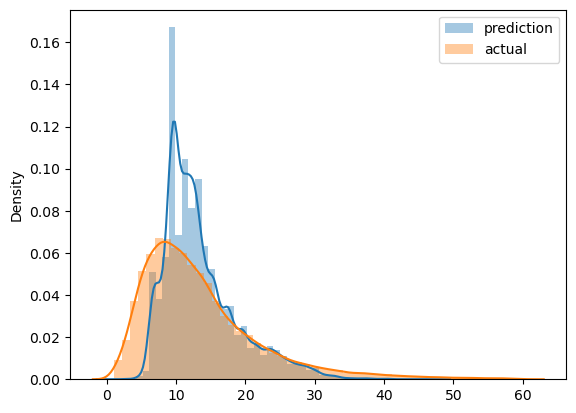

In [39]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [40]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [42]:
df_train = read_dataframe('./data/green_tripdata_2025-01.parquet')
df_val = read_dataframe('./data/green_tripdata_2025-02.parquet')

In [43]:
len(df_train), len(df_val)

(46307, 44218)

In [44]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [54]:
df_val

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,cbd_congestion_fee,duration,PU_DO
0,2,2025-02-01 00:12:15,2025-02-01 00:15:48,N,1.0,166,41,1.0,0.65,6.50,...,0.00,NaN,1.0,10.80,1.0,1.0,0.00,0.00,3.550000,166_41
1,2,2025-01-31 23:57:05,2025-02-01 00:24:24,N,1.0,255,161,1.0,6.57,31.70,...,0.00,NaN,1.0,37.70,2.0,1.0,2.75,0.75,27.316667,255_161
2,2,2025-02-01 00:24:26,2025-02-01 00:49:54,N,1.0,75,182,2.0,8.36,36.60,...,0.00,NaN,1.0,39.10,2.0,1.0,0.00,0.00,25.466667,75_182
3,1,2025-02-01 00:17:15,2025-02-01 00:25:56,N,1.0,97,209,1.0,2.40,12.80,...,0.00,NaN,1.0,22.55,1.0,1.0,2.75,0.75,8.683333,97_209
4,2,2025-02-01 00:17:36,2025-02-01 00:26:36,N,1.0,7,223,1.0,1.31,10.70,...,0.00,NaN,1.0,15.84,1.0,1.0,0.00,0.00,9.000000,7_223
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46616,2,2025-02-28 22:35:00,2025-02-28 23:10:00,None,NaN,181,161,NaN,8.23,44.39,...,0.00,NaN,1.0,56.80,NaN,NaN,NaN,0.75,35.000000,181_161
46617,2,2025-02-28 23:40:00,2025-02-28 23:55:00,None,NaN,166,141,NaN,4.10,27.67,...,0.00,NaN,1.0,38.30,NaN,NaN,NaN,0.00,15.000000,166_141
46618,2,2025-02-28 23:34:00,2025-02-28 23:48:00,None,NaN,41,48,NaN,4.09,27.71,...,0.00,NaN,1.0,32.71,NaN,NaN,NaN,0.75,14.000000,41_48
46619,2,2025-02-28 23:52:00,2025-03-01 00:05:00,None,NaN,75,140,NaN,2.25,16.64,...,0.00,NaN,1.0,21.89,NaN,NaN,NaN,0.00,13.000000,75_140


In [ ]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer() #hot encoding

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [46]:
dv.feature_names_

['PU_DO=101_258',
 'PU_DO=101_82',
 'PU_DO=102_112',
 'PU_DO=102_130',
 'PU_DO=102_236',
 'PU_DO=102_28',
 'PU_DO=102_82',
 'PU_DO=102_95',
 'PU_DO=106_123',
 'PU_DO=106_138',
 'PU_DO=106_14',
 'PU_DO=106_148',
 'PU_DO=106_225',
 'PU_DO=106_228',
 'PU_DO=106_25',
 'PU_DO=106_40',
 'PU_DO=106_61',
 'PU_DO=106_91',
 'PU_DO=107_181',
 'PU_DO=107_185',
 'PU_DO=107_254',
 'PU_DO=107_74',
 'PU_DO=108_108',
 'PU_DO=108_123',
 'PU_DO=108_165',
 'PU_DO=108_210',
 'PU_DO=108_29',
 'PU_DO=108_55',
 'PU_DO=10_10',
 'PU_DO=10_130',
 'PU_DO=10_132',
 'PU_DO=10_139',
 'PU_DO=10_197',
 'PU_DO=10_216',
 'PU_DO=10_218',
 'PU_DO=10_28',
 'PU_DO=10_62',
 'PU_DO=112_107',
 'PU_DO=112_112',
 'PU_DO=112_113',
 'PU_DO=112_114',
 'PU_DO=112_140',
 'PU_DO=112_145',
 'PU_DO=112_148',
 'PU_DO=112_157',
 'PU_DO=112_162',
 'PU_DO=112_164',
 'PU_DO=112_193',
 'PU_DO=112_205',
 'PU_DO=112_225',
 'PU_DO=112_226',
 'PU_DO=112_229',
 'PU_DO=112_230',
 'PU_DO=112_231',
 'PU_DO=112_232',
 'PU_DO=112_237',
 'PU_DO=112_239'

In [51]:
import os
os.makedirs('models', exist_ok=True)

In [47]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [48]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)
# predicting performance of model
root_mean_squared_error(y_val, y_pred)

6.102045306055582

In [52]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [53]:
lr = Lasso(0.01)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

root_mean_squared_error(y_val, y_pred)

8.028312781338874